In [1]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import kerastuner
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from kerastuner.engine.hyperparameters import HyperParameters as hp
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from PIL import Image,ImageStat
import pandas as pd
import numpy as np

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
df = pd.read_csv("../input/chinese-mnist/chinese_mnist.csv")

In [3]:
df.head()

,suite_id,sample_id,code,value,character
0,1,1,10,9,九
1,1,10,10,9,九
2,1,2,10,9,九
3,1,3,10,9,九
4,1,4,10,9,九


In [4]:
df.shape

(15000, 5)

In [5]:
df["value"]

0        9
1        9
2        9
3        9
4        9
        ..
14995    8
14996    8
14997    8
14998    8
14999    8
Name: value, Length: 15000, dtype: int64

In [8]:
print(f"Number of suites: {df.suite_id.nunique()}")
print(f"Samples: {df.sample_id.nunique()}: {list(df.sample_id.unique())}")
print(f"Characters codes: {df.code.nunique()}: {list(df.code.unique())}")
print(f"Characters: {df.character.nunique()}: {list(df.character.unique())}")
print(f"Numbers: {df.value.nunique()}: {list(df.value.unique())}")

Number of suites: 100
Samples: 10: [1, 10, 2, 3, 4, 5, 6, 7, 8, 9]
Characters codes: 15: [10, 11, 12, 13, 14, 15, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Characters: 15: ['九', '十', '百', '千', '万', '亿', '零', '一', '二', '三', '四', '五', '六', '七', '八']
Numbers: 15: [9, 10, 100, 1000, 10000, 100000000, 0, 1, 2, 3, 4, 5, 6, 7, 8]


In [11]:
print(f"frequence of each character:")
df.character.value_counts()

frequence of each character:


九    1000
十    1000
百    1000
千    1000
万    1000
亿    1000
零    1000
一    1000
二    1000
三    1000
四    1000
五    1000
六    1000
七    1000
八    1000
Name: character, dtype: int64

In [12]:
labels = [ [x - 1] for x in df['code'].values ]

In [13]:
y=np.array(labels)

In [14]:
y.shape

(15000, 1)

In [15]:
X = []
for row in range(df.shape[0]):
    suite_id = df["suite_id"].iloc[row]
    sample_id = df["sample_id"].iloc[row]
    code = df["code"].iloc[row]
    file_name = f"input_{suite_id}_{sample_id}_{code}.jpg"
    x =np.array(Image.open(f"../input/chinese-mnist/data/data/{file_name}"))
    X.append(x)
X = np.array(X)
X=X.reshape(15000,64,64,1)

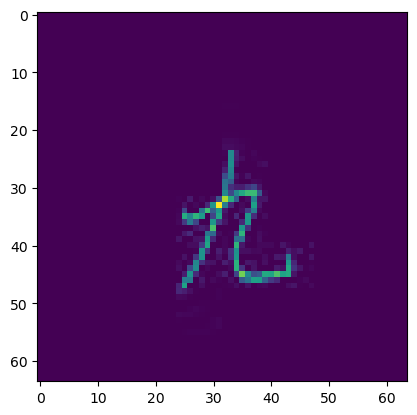

In [16]:
plt.imshow(X[1])

In [17]:
channel_means = np.mean(X)

In [18]:
channel_means

2.200134130859375

In [19]:
X=(X-channel_means)/255.000

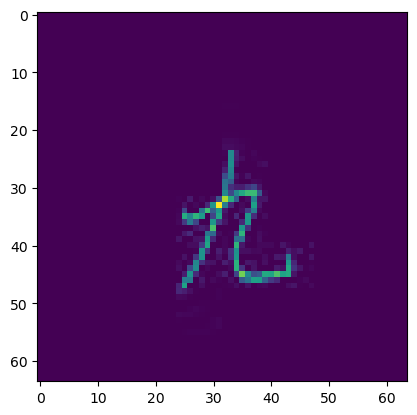

In [20]:
plt.imshow((X[1]))

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
X_train.shape

(12000, 64, 64, 1)

In [23]:
X_test.shape

(3000, 64, 64, 1)

In [24]:
X_train=X_train.reshape(12000, 64, 64,1)
X_test=X_test.reshape(3000, 64, 64,1)

In [25]:
y_train.shape

(12000, 1)

In [26]:
y_train

array([[ 3],
       [ 3],
       [ 1],
       ...,
       [14],
       [ 9],
       [ 1]])

In [27]:
model = Sequential()
model.add(Conv2D(120, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(124, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(15))
model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [28]:
a=model.fit(X_train, y_train, epochs = 45, batch_size=7,validation_data=(X_test, y_test))

Epoch 1/45


2023-06-07 16:57:23.602609: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1715/1715 [==============================] - 27s 9ms/step - loss: 1.3196 - accuracy: 0.5636 - val_loss: 0.4082 - val_accuracy: 0.8713
Epoch 2/45
1715/1715 [==============================] - 13s 8ms/step - loss: 0.5338 - accuracy: 0.8219 - val_loss: 1.6641 - val_accuracy: 0.5047
Epoch 3/45
1715/1715 [==============================] - 14s 8ms/step - loss: 0.3648 - accuracy: 0.8798 - val_loss: 0.3557 - val_accuracy: 0.8693
Epoch 4/45
1715/1715 [==============================] - 13s 8ms/step - loss: 0.3041 - accuracy: 0.9013 - val_loss: 0.1491 - val_accuracy: 0.9453
Epoch 5/45
1715/1715 [==============================] - 13s 8ms/step - loss: 0.2379 - accuracy: 0.9229 - val_loss: 0.3549 - val_accuracy: 0.8947
Epoch 6/45
1715/1715 [==============================] - 13s 8ms/step - loss: 0.2195 - accuracy: 0.9293 - val_loss: 0.1797 - val_accuracy: 0.9447
Epoch 7/45
1715/1715 [==============================] - 13s 7ms/step - loss: 0.1887 - accuracy: 0.9391 - val_loss: 0.3402 - val_accuracy: 0.8

In [29]:
a

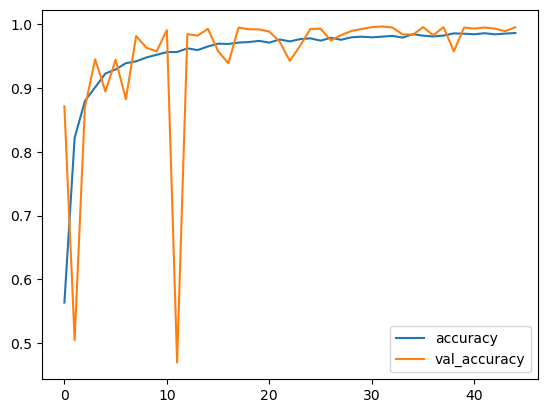

In [30]:
pd.DataFrame(a.history)[['accuracy', 'val_accuracy']].plot()
plt.show()

In [31]:
model.evaluate(X_test, y_test)

94/94 [==============================] - 0s 4ms/step - loss: 0.0121 - accuracy: 0.9953


[0.012137005105614662, 0.9953333139419556]